# Deep Learning Theory: Tutorial
The tutorial consists of two sections. Section 1 is related to **approximation** properties of the ReLU networks, whereas Section 2 is about **expressiveness** of fully connected networks. We will use ``pytorch`` (section 1) and ``numpy`` (section 2).

In [0]:
import torch
from torch import nn

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import requests
import IPython.display as Disp

from IPython.display import clear_output

from tqdm import tqdm_notebook as tqdm

DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'

# Section 1. Approximation battle: Practice vs. Theory

One of the most important problems of the **Deep Learning**, is for a given task to find the **appropriate** neural network architecture. Typically, the word **appropriate** means that the neural network with the given architecture
* Can **efficienty approximate the target function**: not overparametrized ("not many" parameters);
* Is **easy to fit**: has good local minima, optimization converges fast, does not overfit, etc;

For many existing **benchmark** problems (Classification on MNIST, Faces Generation on CelebA, etc.) there exist only receipes which architecture to use (e.g. AlexNets, UNets, ResNets,...), which activations to apply, which heuristics to implement (batchnorms, additional noise, regularization, etc.). All these **recipes** are mainly **based on practical experience** of thousands of researchers.

During this part of the tutorial, we will see that even for the toy artificial problem it is nearly impossible to **practically** develop an efficient ReLU neural network that approximate the desired function well.

## Our goal

The goal is to **solve** the following **approximation problem**:

--------------------------------------------------------------------------------

Design a ReLU network with fewer than 10000 connections that approximates the function $f(x)=\sin x$ on the segment $[-\pi, \pi]$ with uniform error not greater than $10^{-12}$. Implement the network in a Python notebook. Count the number of connections and demonstrate that the error bound is satisfied.

--------------------------------------------------------------------------------

This task is not as easy as it might seem.

## Part 1. Practical Perspectives
We begin with the most straightforward approach: simply to **fit** such a **network from scratch**. We are going to use ``pytorch`` in this section. Make sure that your model you uses ``double`` data type (``float64``). The usage of ``float32`` (default) is not enough to solve the problem.

In the code below please set up the **network architecture** that is, in your opinion, the most suitable for this problem. It may not be necessarily Sequential, may contain **batchnorms** and **droupouts** or any other heuristic you like. The only restriction is that **all the nonlinearities must be ReLUs**.

In [0]:
net = nn.Sequential(
    # Paste your network instead of this one
    nn.Linear(1, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
).to(DEVICE).double()

Althought the number of **connections** does not necessary equal the number of **parameters** (it is greater), for simplicity we equalise these concepts.

Check that your network does not have **too many parameters** (>10000) by launching the code below. 


In [0]:
num_parameters = np.sum([np.prod(par.data.shape) for par in net.parameters()])
if num_parameters > 10000:
  print('Your network has too many parameters! Change it!')
else:
  print('Your network is ok. Move forward!')
print('Number of parameters: {}'.format(num_parameters))

Set the main **training  details**, such as optimizer from ``torch.optim``, number of iterations, batch generation procedure, etc.

In [0]:
def create_batch(batch_size=1024 * 16):
  return torch.rand(batch_size, 1, device=DEVICE, dtype=torch.double) * 2 * np.pi - np.pi

opt = torch.optim.Adam(net.parameters(), lr=1e-3)
max_iterations = 2 ** 14
loss_history = []

Define the loss function. Although we need to optimize **max absolute error**, it is typically reasonable to use **mean absolute error** or (root of) **mean squared error**.

In [0]:
def get_loss(y_true, y_pred):
  return (y_true - y_pred).abs().max()

Train your network. Feel free to do anything 

In [0]:
plot_loss_every = 256
net.train(True)

for iteration in tqdm(range(max_iterations)):
    X = create_batch()
    
    loss = get_loss(torch.sin(X), net(X))
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    loss_history.append(loss.item())
    if iteration % plot_loss_every == 0:
        clear_output(wait=True)
        plt.plot(np.log10(loss_history))
        plt.title('Log10 of loss')
        plt.show()

**Score** your network on segment $[-\pi, \pi]$ to see whether the desired accuracy achieved.

In [0]:
X = torch.linspace(-np.pi, np.pi, 1000000, dtype=torch.double).reshape(-1, 1).to(DEVICE)

net.train(False)
max_error = (net(X) - torch.sin(X)).abs().max().item()

if max_error <= 1e-12:
    print('I do not believe you did it!')
    url = 'https://i.ibb.co/Msqh8GR/what-did-you-say.png'
else:
    print('You failed :(')
    url = 'https://i.ibb.co/J2RzYtB/no-no.jpg'
print('log10 of loss: {}'.format(np.log10(max_error)))

Disp.Image(requests.get(url).content, width=220, height=220)

## Part 2. Theoretical Perspectives
Suprisingly, but the approximation of $sin(x)$ can be reduced simply to approximation of $sqr(x)=x^{2}$. Let us see why!

### Part 2.1. From general to specific
 
#### (1) General Approximation Scheme
Recall that analytic functions can be (locally!) constructed by using only two bivariate functions, sum "$+$" and product "$\cdot$". The **Taylor series** of analytic function is:
$$f(x_{1},x_{2},\dots, x_{n})=f(x_{1}^{0},\dots, x_{n}^{0})+\sum_{i=1}^{n}\frac{\partial f}{\partial x_{i}}\cdot (x_{i}-x_{i}^{0})+\frac{1}{2!}\sum_{i, j}\frac{\partial^{2}f}{x_{i}x_{j}}\cdot (x_{i}-x_{i}^{0})\cdot (x_{j}-x_{j}^{0})+\dots$$
By taking several first turms we obtain (hopefully good) approximation. Every term in the approximation is a **monomial**. Thus, to build an efficient approximation of the function $f$ we can 
* approximate $f$ by several first terms of its Taylor Series
* efficiently approximate the terms (monomials) in series by a neural networks
* sum the approximations for terms

#### (2) Sine Function Approximation

In case of $sin(x)$ function we have:
$$sin(x)=x-\frac{x^{3}}{3!}+\frac{x^{5}}{5!}-\frac{x^{7}}{7!}+\dots.$$
Thus, our **goal** is to **efficiently** approximate monomials $x^{n}$ by the ReLU neural network.

#### (3) Product function approximation

Monomial can be obtained from $x$ by product function, e.g. $x^{n}=prod(x, x^{n-1})$. Thus, we need to efficiently approximate bivariate function
$$prod(x,y)=xy$$
by a ReLU neural network!

#### (4) Square function approximation
Let us start from approximation of $prod(x,x)=sqr(x)=x^2$ for $x\in[0, 1]$. **That is ENOUGH. But why?** Since 
$$prod(x, y)=xy=\big[\frac{(x+y)}{2}\big]^{2}-\big[\frac{(x-y)}{2}\big]^{2},$$
we can use square approximation for product approximation!

$$\tilde{prod}(x, y)=\tilde{sqr}\big(\frac{(x+y)}{2}\big)-\tilde{sqr}\big(\frac{(x-y)}{2}\big).$$

## Part 2.2 Square and product approximation

Efficient ReLU approximation for $x\mapsto x^{2}$ was proposed by D.Yarotskiy, [arXiv:1610.01145](https://arxiv.org/pdf/1610.01145.pdf). It uses the "**tooth**" function.

#### (1) Tooth function
The function is given by
$$g(x)=\begin{cases}
               2x, & x<0.5\\
               2(1-x), & x\geq 0.5
            \end{cases}$$

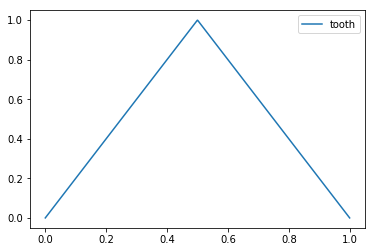

In [2]:
def tooth(x):
  assert x.max().item() <= 1
  assert x.min().item() >= 0
  return (x < 0.5).double() * 2 * x + (x >= 0.5).double() * 2 * (1-x)

X = torch.linspace(0., 1., 1000, device=DEVICE, dtype=torch.double)
plt.plot(X.cpu().numpy(), tooth(X).cpu().detach().numpy(), label='tooth'); plt.legend()

This function is pieswise-linear, thus it can be represented as a weighted sum of ReLU functions (neurons). Please, define it below  the by using Rectifier Linear Units (ReLUs).

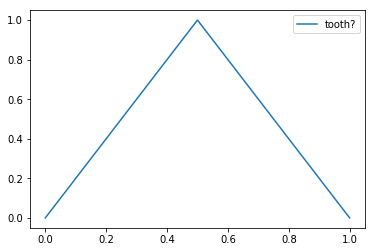

In [3]:
def tooth(x):
  assert x.max().item() <= 1
  assert x.min().item() >= 0
  return torch.relu(2*x) - torch.relu(4*x-2) # SOLUTION

plt.plot(X.cpu().numpy(), tooth(X).cpu().detach().numpy(), label='tooth?'); plt.legend()

#### (2) Sawtooth function
A powerful feature of the tooth function, is that iterated calling it produces **sawtooth** constructions. We denote 
$$g_{s}(x)=\overbrace{g(g(g(\dots g}^{s\text{ times}}(x)))).$$
Let us look at the plot!

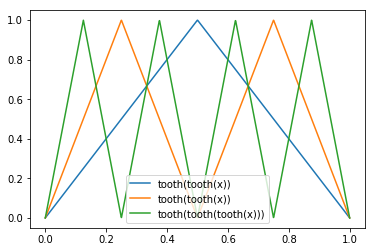

In [4]:
plt.plot(X.cpu().numpy(), tooth(X).cpu().detach().numpy(), label='tooth(tooth(x))');
plt.plot(X.cpu().numpy(), tooth(tooth(X)).cpu().detach().numpy(), label='tooth(tooth(x))');
plt.plot(X.cpu().numpy(), tooth(tooth(tooth(X))).cpu().detach().numpy(), label='tooth(tooth(tooth(x)))');\
plt.legend()

#### (3) Sawtooth approximation of $sqr(x)$
With the help of the following theorem, we are going to implement an efficient approximation of $sqr(x)=x^{2}$ on $[-1, 1]$.
#### Theorem (D. Yarotsky, 2016)
The following function
$$f_{n}(x)=x-\sum_{s=1}^{n}\frac{g_{s}(x)}{2^{2s}}$$
uniformly approximates $x^{2}$ on $[0, 1]$ with error $<2^{-2n-2}$ and can be represented by a ReLU network with $O(n)$ connections:

<br><center><img src="https://i.ibb.co/2hnNXSc/sqr-approx-net.png" alt="sqr-approx-net" border="0"></center></br>

It is easy to add additional layer $|x|=ReLU(x)+ReLU(-x)$ to make the function approximate $x^{2}$ on $[-1, 1]$ instead of $[0, 1]$.

<br><center><img src="https://i.ibb.co/k0Nw3Xf/sqr-approx-net-full.png" alt="sqr-approx-net-full" border="0"></center></br>

From the image it is easy to see that for $n$ blocks the **number of connections** is $5n+5$.

Implement the  described network.

In [0]:
def sqr(x, n_layers=25):
    assert torch.abs(x).max().item() <= 1.
    x = torch.relu(x) + torch.relu(-x)
    
    ans = 1. * x
    sawtooth = 1. * x
    for n in range(n_layers):
        sawtooth = tooth(sawtooth) # SOLUTION
        ans -= 2.**(-2*n-2) * sawtooth # SOLUTION
    return ans

Check the function visually.

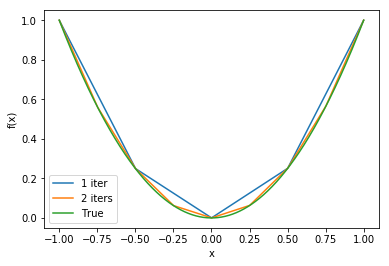

In [7]:
X = torch.linspace(-1, 1, 10000, device=DEVICE, dtype=torch.double)
plt.plot(X.cpu().numpy(), sqr(X, 1).cpu().detach().numpy(), label='1 iter')
plt.plot(X.cpu().numpy(), sqr(X, 2).cpu().detach().numpy(), label='2 iters')
plt.plot(X.cpu().numpy(), (X**2).cpu().detach().numpy(), label='True')
plt.legend(); plt.xlabel('x'); plt.ylabel('f(x)');

Check the improvement of approximation numerically. Run the cell below.

Text(0, 0.5, 'log10(Error)')

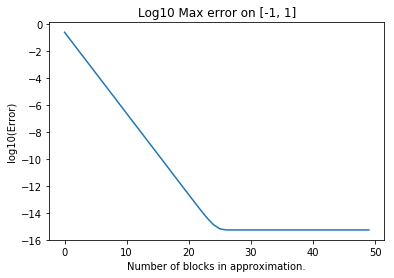

In [8]:
max_errors = []
for n_blocks in tqdm(range(0, 50)):
  error = torch.abs(X ** 2 - sqr(X, n_blocks)).max().item()
  max_errors.append(error)
    
plt.plot(np.log10(max_errors)); plt.xlabel('Number of blocks in approximation.')
plt.title('Log10 Max error on [-1, 1]'); plt.ylabel('log10(Error)')

As you may note, after ~25 layers the accuracy does not improve. This happend due to **hardware precision limitation**. If you use float32 type (single precision) instead of float64 (double precision), the accuracy will stop improving even on ~12 layers (you may also check this!).

#### (3) Sawtooth approximation of product
Approximate the product function $prod(x, y)=xy$ on $[-1, 1]$ by using the approximation of square function.
$$\tilde{prod}(x, y)=\tilde{sqr}\big(\frac{(x+y)}{2}\big)-\tilde{sqr}\big(\frac{(x-y)}{2}\big).$$

In [0]:
def prod(x, y, n_layers=15):
    assert torch.abs(x).max().item() <= 1.
    assert torch.abs(y).max().item() <= 1.
    
    halfsum = (x + y)/2  # SOLUTION
    halfdiff = (x - y) / 2  # SOLUTION

    return sqr(halfsum, n_layers=n_layers) - sqr(halfdiff, n_layers=n_layers)  # SOLUTION

If the inner $\tilde{sqr}$ networks uses $n$ tooth blocks, the $\tilde{prod}$ function will have $(5n+5) * 2 + 6 = 10n+16$ connections.
## Part 2.3. $Sin(x)$ efficient approximation
Note that our functions (approximations of) $sqr(x)$ and $prod(x,y)$ approximate the corresponding function only for $x, y
\in[0,1]$. Thus, we have to monitor that all the inputs to function $sqr, prod$ lie within $[-1, 1]$. Let us denote $z=\frac{x}{\pi}$. Then
$$sin(x)=sin(2\pi z)=\sum_{n=0}^{\infty}(-1)^{n}z^{2n+1}\frac{(2\pi)^{2n+1}}{(2n+1)!}.$$
Now we can efficiently compute all the powers of $z$, multiply them by coefficients $\frac{(2\pi)^{2n+1}}{(2n+1)!}<10$ (this will only decrease accuracy not worse than 10 times) and sum the obtained values.

<br><center><img src="https://i.ibb.co/MZGTffQ/sin-approx-net-full.png" alt="sin-approx-net" border="0" height=300></center></br>

If $m$ first taylor series terms are used for approximation and each sqr block uses $n$ tooth blocks, the total number of connections in the network is:
$$\text{total connctions}=1+\underbrace{(5n+5)}_{\text{sqr block}}+(m-1) * \underbrace{(10n+16)}_{\text{prod block}}+m$$

For $m=20$ and $n=25$ the exact **number of connections is 5180**.

Now your job is to **implement this network**.


In [0]:
def sin(x, terms=20, sqr_layers=25):
    z = x / np.pi
    
    ans = z
    pow_z = z
    sqr_z = sqr(z, n_layers=sqr_layers)
    ratio = 1.
    for n in tqdm(range(1, terms)):
        pow_z = prod(pow_z, sqr_z, n_layers=sqr_layers)  # SOLUTION
        
        sign = 1 if n % 2 == 0 else -1
        
        ratio *= np.square(np.pi) / ((2*n) * (2*n+1))
        ans += sign * ratio * pow_z  # SOLUTION
    ans *= np.pi
    
    return ans

Check what you have done!

In [0]:
X = torch.linspace(-np.pi+1e-12, np.pi-1e-12, 10000, device=DEVICE, dtype=torch.double)
sinX = sin(X)

plt.plot(X.cpu().numpy(), sinX.cpu().detach().numpy())

max_error = torch.abs(torch.sin(X) - sinX).max().item()
log10_error = np.log10(max_error)

if log10_error < -12:
    print('Success! You are awesome!')
    url = "https://i.ibb.co/DVqCb8K/perfect.png"
else:
    print('Too huge error!')
    url = 'https://i.ibb.co/J2RzYtB/no-no.jpg'
    
print('log10 max error: {}'.format(round(np.log10(max_error), 2)))
Disp.Image(requests.get(url).content, width=220, height=220)

## Part 2.4. Can you fit such a monster?
Even when we know the good architecture, we are not able to fit it. Or can we?
Let us implement the Sqr Neural network but (in contrast to previous approach) with weights as choosable parameters.

In [0]:
class SqrNet(nn.Module):
  def __init__(self, n_layers=25):
    super(SqrNet, self).__init__()
    self.tooth = nn.Sequential(
        nn.Linear(1, 2, bias=True),
        nn.ReLU(),
        nn.Linear(2, 1, bias=False)
    )
    
    self.n_layers = n_layers
    
    self.abs = nn.Sequential(
        nn.Linear(1, 2, bias=False),
        nn.ReLU(),
        nn.Linear(2, 1, bias=False)
    )
    
    self.main = nn.Linear(n_layers+1, 1)
    
  def forward(self, x):
    x = self.abs(x)
    layers = [x]
    for _ in range(self.n_layers):
      layers.append(self.tooth(layers[-1]))
    layers = torch.cat(layers, dim=1)
    return self.main(layers)

torch.manual_seed(0xBADBAAD)
sqr_net = SqrNet(n_layers=4).to(DEVICE).double()

Now we try to fit such the problem-specific neural network to represent the function $sqr(x)=x^{2}$. Can we achieve accuracy $10^{-12}$?

In [0]:
def get_loss(y_true, y_pred):
  return (y_true - y_pred).abs().mean()

opt = torch.optim.Adam(sqr_net.parameters(), lr=1e-3, weight_decay=1e-3)
max_iterations = 2 ** 12
loss_history = []

plot_loss_every = 128
sqr_net.train(True)

for iteration in tqdm(range(max_iterations)):
    X = torch.rand(10000, 1, device=DEVICE, dtype=torch.float64) * 2 - 1
    
    loss = get_loss(X ** 2, sqr_net(X))
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    loss_history.append(loss.item())
    if iteration % plot_loss_every == 0:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 4, figsize=(20, 4))
        axes[0].plot(np.log10(loss_history))
        axes[0].set_title('Log10 of loss')
        
        X = torch.linspace(-10, 10, 1000, device=DEVICE, dtype=torch.double).reshape(-1, 1)
        axes[1].plot(X.cpu().numpy(), sqr_net(X).cpu().detach().numpy(), label='Sqr Net')
        axes[1].plot(X.cpu().numpy(), (X**2).cpu().detach().numpy(), label='True')
        axes[1].legend(); axes[1].set_xlabel('x'); axes[1].set_ylabel('f(x)');
        
        axes[2].plot(X.cpu().numpy(), sqr_net.abs(X).cpu().detach().numpy(), label='Fitted Abs Function')
        axes[2].legend(); axes[2].set_xlabel('x'); axes[2].set_ylabel('abs(x)');
                
        X = torch.linspace(-10, 10, 1000, device=DEVICE, dtype=torch.double).reshape(-1, 1)
        axes[3].plot(X.cpu().numpy(), sqr_net.tooth(X).cpu().detach().numpy(), label='Fitted Tooth Function')
        axes[3].legend(); axes[3].set_xlabel('x'); axes[3].set_ylabel('tooth(x)');
        
        plt.show()

## Part 3. Homework
* Prove theoretically that the obtained network attains the desired maximal absolute error $<10^{-12}$. You may want to use the theorem from above.

# Section 2. Expressiveness analysis via propagation in random neural networks

In this part of the tutorial we will try to understand some expressiveness-related properties of the neural networks. We will study how the signal propagates through the neural network. Here for simplicity we will use ``numpy`` instead of ``pytorch``.

Consider the fully connected neural network with layer width $d_{0},d_{1},\dots d_{n}\rightarrow \infty$:
$$x_{n}=h\bigg(W_{n}\cdot h\big(W_{n-1}\cdot h(\dots)+b_{n-1}\big)+b_{n}\bigg)$$
with the following sequential decomposition:
$$x_{1}=\sigma(W_{1}\cdot x_{0}+b_{1});\qquad x_{2}=\sigma(W_{2}\cdot x_{1}+b_{2});\qquad ..\qquad x_{n}=\sigma(W_{n}x_{n-1}+b_{n}),$$

Here  $W_{k}\in \mathbb{R}^{d_{k}\times d_{k-1}}$ are weight matrices, $b_{k}\in
\mathbb{R}^{d_{k}}$ are bias vectors, $x_{0}$ is the input vector. Schematically, $k$-th block is given by
$$z_{k}=W_{k}x_{k-1}+b_{k}; \qquad x_{k}=\sigma(z_{k})$$
<center><img src="https://i.ibb.co/VCYnD8T/block.png" alt="block" height=200></center>

Consider the **random initialization** of weights:
* Weights $(W_k)_{ij}$ are i.i.d. with mean $0$ and variance $\frac{\sigma_{w}^{2}}{d_{k-1}}$
* Biases $(h_k)_{i}$ are i.i.d. with mean $0$ and variance $\sigma_{h}^{2}$

In [0]:
np.random.seed(0xBADBEEF)

d = 300
K = 100

std_w = 0.8
std_b = 1.

Wlist = [np.random.randn(d,d) for k in range(K)]
hList = [np.random.randn(d,1) for k in range(K)]

actL = ['relu', 'leaky_relu', 'tanh']
colors = dict([(actL[n], ['b','r','g'][n]) for n in range(3)])

def h(x, activation):
    if activation == 'relu':
        return np.clip(x, 0,np.inf)
    elif activation == 'leaky_relu':
        return x.clip(0,np.inf)+0.5*x.clip(-np.inf,0)
    elif activation == 'tanh':
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    
def propagate(z0, activation, std_w, std_b):    
    zList = [z0]
    xList = [h(z0, activation)]
    for k in range(K):  
        np.dot(Wlist[k], xList[-1])
        x_old = xList[-1]
        z = np.dot(std_w/np.sqrt(d)*Wlist[k], x_old)+std_b*hList[k]
        x = h(z, activation)
        zList.append(z)
        xList.append(x)
    return xList, zList

For simplicity, we assume that $z_{0}$ is the input to the network (instead of $x_{0}$), and investigate the propagation of $z_{0},z_{1},\dots, z_{n}$, which is given by
$$z_{1}=W_{1}\cdot h(z_{0})+b_{0}; \qquad z_{2}=W_{2}\cdot h(z_{1})+b_{1};\qquad \dots \qquad z_{n}=W_{n}\cdot h(z_{n-1})+b_{n}.$$
Let us see what happens with two independent random vectors $z, z'$ propagated through the network. Will their values at the last layers will also be independent?
we compute the correlation coefficient
$$c_{k}=\frac{\langle z_{k},z_{k}''\rangle}{\|z_{k}\|\cdot \|z_{k}'\|}$$.

In [0]:
plt.figure(figsize=(8,6))
z01 = np.random.randn(d,1)
z02 = np.random.randn(d,1)
for activation in actL:
    xList1, zList1 = propagate(z01, activation, std_w, std_b)
    xList2, zList2 = propagate(z02, activation, std_w, std_b)
    cList = [np.sum(zList1[k]*zList2[k])/np.sqrt(np.sum(zList1[k]**2)*np.sum(zList2[k]**2)) for k in range(K)] # SOLUTION
    plt.plot(cList, colors[activation], label=activation)

plt.xlabel('layer (k)')
plt.ylabel('correlation coefficient')
plt.legend()
plt.show()

Is this a good result? **Definitely NO!** We see that that two independent vectors become **highly correlated**!
Deep Learning Theory says that the correlation depends on the magnitudes of the signal. So, before understanding the correlation phenomena let us analyse **magnitudes**.

## Part 1.1. Empirical Analysis of Magnitude

To analyze the magnitude, we formally define it:
$$\text{k-th Layer Signal Magnitude}= q_{k}\stackrel{def}{=} \frac{\|z_{k}\|^{2}}{d_{k}}=\frac{\sum_{i=1}^{d_{k}}z_{k,i}^{2}}{d_{k}}$$

**Question:** what is the desired behavious of the magnitude? For analysis, it is easier to consider simple cases:

* Magnitude is a **FIXED** point: $q_{0}=q_{1}=\dots=q_{n}$
* Magnitude converges to **STABLE** fixed point: $\lim_{k\rightarrow \infty} q_{k}=q^{*}$

To begin with, we define the function that propagates the signal through the network.

Let us see, how the magnitude of the signal evolves through the layers for given

In [0]:
plt.figure(figsize=(8,6))
z0 = np.random.randn(d,1)
for activation in actL:
    xList, zList = propagate(z0, activation, std_w, std_b)
    qList = [np.sum(z*z)/d for z in zList]
    plt.plot(qList, colors[activation], label=activation)

plt.xlabel('layer (k)')
plt.ylabel('q')
plt.legend()
plt.show()



We see that the signal's magnitude become more-or-less stable. Let us try to understand whether it is a coincidence.

## Part 1.2. Theoretical Magnitude Analysis
Assume that the layer width $d_{1},\dots,d_{n}\gg 1$. By the **Law of Large numbers** magnitude $q_k$ is approximately constant, i.e.
$$q_k=\frac{\sum_{i=1}^{d_{k}}z_{k,i}^{2}}{d_{k}} ≈ \mathbb{E}z_{k,i}$$.

**Proposition (Poole et al., [arXiv:1606.05340](https://arxiv.org/abs/1606.05340))**

The evolution of magnitude $q_k$ is given by
$$q_{k}=\nu(q_{k-1}|\sigma_{w},\sigma_{b})=\sigma_{w}^{2}\cdot \mathbb{E}_{s\sim \mathcal{N}(0, 1)} \big[h^{2}(\sqrt{q_{k-1}}s)\big]+\sigma_{b}^{2}.$$

The proof is based on Central Limit Theorem & Law of Large numbers.

It is hard to compute the exact value for an arbitrary activation function $h$, but empirically it can be estimated by Monte Carlo sampling of $s$. Your job is to implement the Monte-Carlo estimate of function $\nu$.

In [0]:
def nu(q, activation, std_w, std_b):
    N = 10000
    s = np.random.randn(N)
    expectation = np.mean(h(np.dot(np.sqrt(q).reshape(-1,1), s.reshape(1,-1)), activation)**2, axis=1) # SOLUTION
    q_new = std_w**2 * expectation +std_b**2
    return q_new 

Now we plot the function $\nu(q)$ and for different activation function compute its fixed points $q^{*}$ (such that $\nu(q^{*})=q^{*}$).
.

In [0]:
q = np.linspace(0,3)
q_fixedD = {}

plt.figure(figsize=(8,6))
for activation in actL:
    print('====', activation)
    q_new = nu(q, activation, std_w, std_b)
    plt.plot(q, q_new, colors[activation], label=activation, )
    q_fixed = 1
    for k in range(100):
        q_fixed = nu(q_fixed, activation, std_w, std_b)
    q_fixedD[activation] = q_fixed[0]
    print('Stable fixed point:', q_fixedD[activation])
    plt.plot([q_fixed], [q_fixed], colors[activation]+'s')

plt.plot(q, q, 'k', label='Id')
plt.xlabel('$q$', fontsize=15)
plt.ylabel('$\\nu(q)$', fontsize=15)
plt.legend()
plt.show()

We plot the magnitude evolution together with found stable points.

In [0]:
plt.figure(figsize=(8,6))
z0 = np.random.randn(d,1)
for activation in actL:
    xList, zList = propagate(z0, activation, std_w, std_b)
    qList = [np.sum(z*z)/d for z in zList]
    plt.plot(qList, colors[activation], label=activation)
    plt.plot(q_fixedD[activation]*np.ones(len(qList)), colors[activation]+':', label=activation+': fixed point')

plt.xlabel('layer (k)', fontsize=15)
plt.ylabel('$q$', fontsize=15)
plt.legend()
plt.show()

As we see, practical derivations confirm theoretical findings.

**Question:** Is the current chosen variance $\sigma_{w}^{2}, 
\sigma_{b}^{2}$ good?

**Question:** Why is the result should be considered as bad?

## Part 3. Theoretical Correlation Analysis

We analyze the relations between signal evolution in network for two different vectors. Let $z_{0,1}$ and $z_{0,2}$ be two input vectors. Define the **correlation** by
$$q_{k,ab}=\frac{1}{d_{k}}\langle z_{k,a},z_{k, b}\rangle$$
for $a,b\in \{0, 1\}$.

**Question:** How does $q_{k,ab}$ evolve?

We already now how $q_{k,aa}=q_{k}$ evolve! The evolution of $q_{k,01}$ may not be that interesting, if we do not take into account the value of the norms of the corresponding vectors $z_{k, 0}$ and $z_{k, 1}$. Thus, we correlation coefficient:
$$c_{k,12}=\frac{q_{k,12}}{\sqrt{q_{k,1}q_{k,2}}}$$
Implement the function to compute the correlation coefficient.

Similar to magnitude analysis, it is possible to provide exact analytical form of correlation evolution (see Poole et al., [arXiv:1606.05340](https://arxiv.org/abs/1606.05340)).

$$q_{k,12}=\mathcal{Q}(q_{k-1,12}, q_{k-1,11}, q_{k-1,22})=[\text{Some Heavy formula}]$$

We consider only the cases, which are the most interesting, i.e. when both $q_{k,11}$ and $q_{k,22}$ are the stable points of the corresponding evolution function $\nu$.
$$\nu(q^{*})=q{*}=q_{k,11}=q_{k,22}$$

Thus, the correlation $c_{k,12}$ (and the covariation $q_{k,12}$) can be expressed as the function of $c_{k-1, 12}$. We denote this function by
$$c_{k,12}=\mathcal{C}_{q^{*}}(c_{k-1,12}).$$
It is quive obvious that $c^{*}=1$ is a fixed point of this map

**Question:** Is $c^{*}$ stable or not stable?

If $c^{*}=1$ is stable, then **we are in trouble**. Think WHY? SO we want this point to be unstable. The stability is determined by the derivative in $c^{*}=1$, which is given by:
$$\chi_{1}=\frac{\partial c_{k,12}}{\partial c_{k-1,12}}|_{c=1}=\sigma_{w}^{2}\int\big(h'(\sqrt{q^{*}}s)\big)^{2}\mathcal{D}s$$

* Stable ($|\chi_{1}| < 1$):
 * different input vectors converge
 * initial details in the input get lost
 * deep network has low expressiveness
* Unstable ($|\chi_{1}| > 1$):
 * close input vectors tend to decorrelate
 * small changes in the input lead to major deviations
 * deep network has high expressiveness

In [0]:
def chi1(std_w, q_fixed):
    N = 10000
    s = np.random.randn(N)
    u = np.dot(np.sqrt(q_fixed).reshape(-1,1), s.reshape(1,-1))
    eps = 1e-10
    h_deriv = (h(u+eps, activation)-h(u-eps, activation))/(2*eps)
    integral = np.mean(h_deriv**2)
    return std_w**2*integral  

We compute the derivatives for different activation functions.

In [0]:
for activation in actL:
    print('====', activation)
    print('Chi1:', chi1(std_w, q_fixedD[activation]))

Now we change the net weight initialisation variance ($\sigma_{w}$ and $\sigma_{b}$) and again compute the stable fixed points.

In [0]:
std_w = 1.24
std_b = 0.1

q = np.linspace(0,0.5)
q_fixedD = {}

plt.figure(figsize=(8,6))
for activation in actL:
    print('====', activation)
    q_new = nu(q, activation, std_w, std_b)
    plt.plot(q, q_new, colors[activation], label=activation, )
    q_fixed = 1
    for k in range(1000):
        q_fixed = nu(q_fixed, activation, std_w, std_b)
    q_fixedD[activation] = q_fixed[0]
    print('Stable fixed point:', q_fixedD[activation])
    plt.plot([q_fixed], [q_fixed], colors[activation]+'s')

plt.plot(q, q, 'k', label='Id')
plt.xlabel('$q$', fontsize=15)
plt.ylabel('$\\nu(q)$', fontsize=15)
plt.legend()
plt.show()

In [0]:
plt.figure(figsize=(8,6))
z0 = np.random.randn(d,1)
for activation in actL:
    xList, zList = propagate(z0, activation, std_w, std_b)
    qList = [np.sum(z*z)/d for z in zList]
    plt.plot(qList, colors[activation], label=activation)
    plt.plot(q_fixedD[activation]*np.ones(len(qList)), colors[activation]+':', label=activation+': fixed point')

plt.xlabel('layer (k)', fontsize=15)
plt.ylabel('$q$', fontsize=15)
plt.legend()
plt.show()

We again compute the derivative of the correlation mapping at the point $c^{*}=1$.

In [0]:
for activation in actL:
    print('====', activation)
    print('Chi1:', chi1(std_w, q_fixedD[activation]))

It seems that only for $tanh$ the fixed point $c^{*}=1$ is not stable.

In [0]:
plt.figure(figsize=(8,6))
z01 = np.random.randn(d,1)
z02 = z01+0.7*np.random.randn(d,1)
for activation in actL:
    xList1, zList1 = propagate(z01, activation, std_w, std_b)
    xList2, zList2 = propagate(z02, activation, std_w, std_b)
    qList = [np.sum(z*z) for z in zList]
    cList = [np.sum(zList1[n]*zList2[n])/np.sqrt(np.sum(zList1[n]**2)*np.sum(zList2[n]**2)) for n in range(K)]
    plt.plot(cList, colors[activation], label=activation)

plt.xlabel('layer (k)')
plt.ylabel('correlation coefficient')
plt.legend()
plt.show()

## Part 3. Homework
* Prove that $tanh$ correlation mapping $C$ has stable point $c^{*}\neq 1$.
* Find the explicit form of the correlation evolution map e $\mathcal{C}$ for the ReLU nonlinearity.